In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import datetime as dt
from scipy.stats import skew, kurtosis
from sklearn import preprocessing, model_selection, metrics

import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
import os
pd.options.display.max_columns = 1000

In [2]:
DATA_PATH = Path("data/")

In [3]:
train = pd.read_csv(DATA_PATH/"train.csv", parse_dates=["impression_time"])
test = pd.read_csv(DATA_PATH/"test.csv", parse_dates=["impression_time"])

view_log = pd.read_csv(DATA_PATH/"view_log.csv", parse_dates=["server_time"])
item_data = pd.read_csv(DATA_PATH/"item_data.csv")

view_log_item_data = view_log.merge(item_data, on="item_id", how="left")

In [4]:
view_log_item_data["hour"] = view_log_item_data["server_time"].dt.hour

In [5]:
app_code_agg1 = train.groupby("app_code").agg({"is_click": "mean"})

In [6]:
view_log_item_data.head(10)

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type,hour
0,2018-10-15 08:58:00,android,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0,8
1,2018-10-15 08:58:00,android,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0,8
2,2018-10-15 08:58:00,android,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0,8
3,2018-10-15 08:58:00,android,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0,8
4,2018-10-15 08:58:00,android,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0,8
5,2018-10-15 08:58:00,android,635314,87387,86660,10304.0,1.0,7.0,300.0,10149.0,8
6,2018-10-15 08:58:00,android,482459,348,35370,480.0,0.0,6.0,50.0,1457.0,8
7,2018-10-15 08:58:00,android,218564,19227,100065,1587.0,4.0,74.0,292.0,1945.0,8
8,2018-10-15 08:58:00,android,947548,30183,86558,9920.0,13.0,78.0,1.0,5526.0,8
9,2018-10-15 08:58:00,android,941129,31754,127900,3520.0,1.0,28.0,283.0,908.0,8


In [7]:
agg_base = view_log_item_data[view_log_item_data['server_time'] >= '2018-11-15']
           
agg_base["dayofweek"] = agg_base["server_time"].dt.dayofweek
agg_base["hour"] = agg_base["server_time"].dt.hour

In [8]:
agg_base1 = agg_base.groupby(["user_id","hour"]).agg({"server_time": [("user_count_bhr", "count")],
#                                                                "device_type": [("num_device_types", lambda x: np.unique(x).size)],
                                                 "session_id": [("num_sessions_bhr", lambda x: np.unique(x).size)],
                                                 "item_id": [("num_items_bhr", lambda x: np.unique(x).size)],
                                                 "item_price": [("mean_item_price_bhr", "mean"),
                                                                ("min_item_price_bhr", "min"),
                                                                ("max_item_price_bhr", "max")
#                                                                                 ("skew_item_price", lambda x: skew(x)),
#                                                                                 ("kurtosis_item_price", lambda x: kurtosis(x))
                                                               ],
                                                 "category_1": [("num_category_1_bhr", lambda x: np.unique(x).size)],
                                                 "category_2": [("num_category_2_bhr", lambda x: np.unique(x).size)],
                                                 "category_3": [("num_category_3_bhr", lambda x: np.unique(x).size)],
                                                 "product_type": [("num_product_type_bhr", lambda x: np.unique(x).size)],
                                                })
agg_base1.columns = agg_base1.columns.droplevel()
agg_base1 = agg_base1.reset_index(drop=False)

In [9]:
agg_base2 = agg_base.groupby(["user_id","dayofweek"]).agg({"server_time": [("user_count_bdow", "count")],
#                                                                "device_type": [("num_device_types", lambda x: np.unique(x).size)],
                                                 "session_id": [("num_sessions_bdow", lambda x: np.unique(x).size)],
                                                 "item_id": [("num_items_bdow", lambda x: np.unique(x).size)],
                                                 "item_price": [("mean_item_price_bdow", "mean"),
                                                                ("min_item_price_bdow", "min"),
                                                                ("max_item_price_bdow", "max")
#                                                                                 ("skew_item_price", lambda x: skew(x)),
#                                                                                 ("kurtosis_item_price", lambda x: kurtosis(x))
                                                               ],
                                                 "category_1": [("num_category_1_bdow", lambda x: np.unique(x).size)],
                                                 "category_2": [("num_category_2_bdow", lambda x: np.unique(x).size)],
                                                 "category_3": [("num_category_3_bdow", lambda x: np.unique(x).size)],
                                                 "product_type": [("num_product_type_bdow", lambda x: np.unique(x).size)],
                                                })
agg_base2.columns = agg_base2.columns.droplevel()
agg_base2 = agg_base2.reset_index(drop=False)

In [10]:
app_code_agg1.columns = ['mn_isclick_appcode']
app_code_agg1 = app_code_agg1.reset_index(drop = False)

In [11]:
app_code_agg1.head(10)

,app_code,mn_isclick_appcode
0,0,0.082192
1,1,0.085714
2,2,0.067164
3,3,0.034424
4,4,0.000000
5,5,0.073306
6,6,0.000000
7,7,0.058366
8,8,0.156250
9,9,0.063800


In [12]:
tmp = view_log_item_data.groupby("user_id").agg({"server_time": [("user_count", "count")],
#                                                                "device_type": [("num_device_types", lambda x: np.unique(x).size)],
                                                 "session_id": [("num_sessions", lambda x: np.unique(x).size)],
                                                 "item_id": [("num_items", lambda x: np.unique(x).size)],
                                                 "item_price": [("mean_item_price", "mean"),
                                                                ("min_item_price", "min"),
                                                                ("max_item_price", "max"),
                                                                ("sd_item_price", lambda x: np.std(x))
#                                                                                 ("skew_item_price", lambda x: skew(x)),
#                                                                                 ("kurtosis_item_price", lambda x: kurtosis(x))
                                                               ],
                                                 "category_1": [("num_category_1", lambda x: np.unique(x).size)],
                                                 "category_2": [("num_category_2", lambda x: np.unique(x).size)],
                                                 "category_3": [("num_category_3", lambda x: np.unique(x).size)],
                                                 "product_type": [("num_product_type", lambda x: np.unique(x).size)],
                                                })
tmp.columns = tmp.columns.droplevel()
tmp = tmp.reset_index(drop=False)

In [13]:
tmpx = view_log_item_data[view_log_item_data['server_time'] >= '2018-11-15'].groupby("user_id").agg({"server_time": [("user_count_rct", "count")],
#                                                                "device_type": [("num_device_types", lambda x: np.unique(x).size)],
                                                 "session_id": [("num_sessions_rct", lambda x: np.unique(x).size)],
                                                 "item_id": [("num_items_rct", lambda x: np.unique(x).size)],
                                                 "item_price": [("mean_item_price_rct", "mean"),
                                                                ("min_item_price_rct", "min"),
                                                                ("max_item_price_rct", "max"),
                                                                ("sd_item_price_rct", lambda x: np.std(x))
#                                                                                 ("skew_item_price", lambda x: skew(x)),
#                                                                                 ("kurtosis_item_price", lambda x: kurtosis(x))
                                                               ],
                                                 "category_1": [("num_category_1_rct", lambda x: np.unique(x).size)],
                                                 "category_2": [("num_category_2_rct", lambda x: np.unique(x).size)],
                                                 "category_3": [("num_category_3_rct", lambda x: np.unique(x).size)],
                                                 "product_type": [("num_product_type_rct", lambda x: np.unique(x).size)],
                                                })
tmpx.columns = tmpx.columns.droplevel()
tmpx = tmpx.reset_index(drop=False)

In [14]:
tmp1 = view_log_item_data.pivot_table(index="user_id", 
                                      columns="category_1", 
                                      values="server_time", aggfunc="count").fillna(0)
tmp1.columns.name = None
tmp1.columns = [f"category_1_{int(category_type)}" for category_type in tmp1.columns]
tmp1 = tmp1.reset_index()

In [15]:
tmpx1 = view_log_item_data[view_log_item_data['server_time'] >= '2018-11-15'].pivot_table(index="user_id", 
                                      columns="category_1", 
                                      values="server_time", aggfunc="count").fillna(0)
tmpx1.columns.name = None
tmpx1.columns = [f"category_1_rct_{int(category_type)}" for category_type in tmpx1.columns]
tmpx1 = tmpx1.reset_index()

In [16]:
tmp2 = view_log_item_data.pivot_table(index="user_id", 
                                      columns="category_2", 
                                      values="server_time", aggfunc="count").fillna(0)
tmp2.columns.name = None
tmp2.columns = [f"category_2_{int(category_type)}" for category_type in tmp2.columns]
tmp2 = tmp2.reset_index()

In [17]:
tmpx2 = view_log_item_data[view_log_item_data['server_time'] >= '2018-11-15'].pivot_table(index="user_id", 
                                      columns="category_2", 
                                      values="server_time", aggfunc="count").fillna(0)
tmpx2.columns.name = None
tmpx2.columns = [f"category_2_rct_{int(category_type)}" for category_type in tmpx2.columns]
tmpx2 = tmpx2.reset_index()

In [55]:
train["is_train"] = 1
test["is_train"] = 0

panel = pd.concat([train, test], sort=False, ignore_index=True)

In [56]:
panel = (panel.merge(tmp, on="user_id", how="left")
              .merge(tmp1, on="user_id", how="left")
              .merge(tmp2, on="user_id", how="left")
        .merge(tmpx, on="user_id", how="left")
        .merge(tmpx1, on="user_id", how="left")
        .merge(tmpx2, on="user_id", how="left")
        .merge(app_code_agg1,on='app_code',how ='left'))

In [57]:
os_version_mapper = {"latest": 2, "intermediate": 1, "old": 0}
panel["os_version"] = panel["os_version"].map(os_version_mapper)

In [58]:
# panel["day"] = panel["impression_time"].dt.day
panel["dayofweek"] = panel["impression_time"].dt.dayofweek
panel["hour"] = panel["impression_time"].dt.hour

In [59]:
for col in ["user_id", "app_code", 
            ["user_id", "app_code"], ["app_code", "os_version"]]:
    if not isinstance(col, list):
        col = [col]
    col_name = "_".join(col)
    all_df = panel[["impression_id"] + col].copy()
    gdf = all_df.groupby(col)["impression_id"].count().reset_index()
    gdf.columns = col + [col_name+"_count"]
    panel = pd.merge(panel, gdf, on=col, how="left")

In [60]:
tpx = panel.groupby(["app_code"]).agg({"user_id":(lambda x: np.unique(x).size),
                                      "num_sessions":"sum",
                                       "num_items":"sum",
                                       "mean_item_price":"mean",
                                       "min_item_price":"min",
                                       "max_item_price":"max",
                                      "num_sessions_rct":"sum",
                                       "num_items_rct":"sum",
                                       "mean_item_price_rct":"mean",
                                       "min_item_price_rct":"min",
                                       "max_item_price_rct":"max"
                                      })
#tpx.columns = tpx.columns.droplevel()
tpx.columns = ["ac_user_count","ac_num_sessions","ac_num_items","ac_mean_item_price","ac_min_item_price","ac_max_item_price",
 "ac_num_sessions_rct","ac_num_items_rct","ac_mean_item_price_rct","ac_min_item_price_rct","ac_max_item_price_rct"
              ]
tpx = tpx.reset_index(drop= False)
tpx.head(5)

,app_code,ac_user_count,ac_num_sessions,ac_num_items,ac_mean_item_price,ac_min_item_price,ac_max_item_price,ac_num_sessions_rct,ac_num_items_rct,ac_mean_item_price_rct,ac_min_item_price_rct,ac_max_item_price_rct
0,0,39,1527,2861,11418.962507,64.0,343040.0,944.0,1827.0,12217.558211,64.0,343040.0
1,1,28,871,1173,12308.724361,80.0,209024.0,446.0,625.0,10608.803759,102.0,209024.0
2,2,67,2295,5912,9748.932723,17.0,258240.0,1153.0,3013.0,9207.570299,17.0,205440.0
3,3,2479,143168,243262,11221.969851,6.0,648960.0,70677.0,132110.0,11826.147316,6.0,648960.0
4,4,2,19,31,12050.324786,313.0,48320.0,4.0,10.0,20427.166667,313.0,48320.0


In [61]:
tpx1 = panel.groupby(["os_version"]).agg({"user_id":(lambda x: np.unique(x).size),
                                      "num_sessions":"sum",
                                       "num_items":"sum",
                                       "mean_item_price":"mean",
                                       "min_item_price":"min",
                                       "max_item_price":"max"
                                      "num_sessions_rct":"sum",
                                       "num_items_rct":"sum",
                                       "mean_item_price_rct":"mean",
                                       "min_item_price_rct":"min",
#                                        "max_item_price_rct":"max"
                                      })
#tpx.columns = tpx.columns.droplevel()
tpx1.columns = ["ov_user_count","ov_num_sessions","ov_num_items","ov_mean_item_price","ov_min_item_price","ov_max_item_price"
              ,"ov_num_sessions_rct","ov_num_items_rct","ov_mean_item_price_rct","ov_min_item_price_rct","ov_max_item_price_rct"
              ]
tpx1 = tpx1.reset_index(drop= False)
tpx1.head(5)

In [62]:
tpx2 = panel.groupby(["user_id"]).agg({"user_id":(lambda x: np.unique(x).size),
                                      "num_sessions":"sum",
                                       "num_items":"sum",
                                       "mean_item_price":"mean",
                                       "min_item_price":"min",
                                       "max_item_price":"max",
                                      "num_sessions_rct":"sum",
                                       "num_items_rct":"sum",
                                       "mean_item_price_rct":"mean",
                                       "min_item_price_rct":"min",
                                       "max_item_price_rct":"max"
                                      })
#tpx.columns = tpx.columns.droplevel()
tpx2.columns = ["ov_user_count","ov_num_sessions","ov_num_items","ov_mean_item_price","ov_min_item_price","ov_max_item_price"
              ,"ov_num_sessions_rct","ov_num_items_rct","ov_mean_item_price_rct","ov_min_item_price_rct","ov_max_item_price_rct"
              ]
tpx2 = tpx2.reset_index(drop= False)
tpx2.head(5)

,user_id,ov_user_count,ov_num_sessions,ov_num_items,ov_mean_item_price,ov_min_item_price,ov_max_item_price,ov_num_sessions_rct,ov_num_items_rct,ov_mean_item_price_rct,ov_min_item_price_rct,ov_max_item_price_rct
0,0,1,11,18,9395.666667,332.0,92160.0,5.0,6.0,4246.181818,1152.0,19840.0
1,1,1,3,8,3946.750000,383.0,12595.0,1.0,6.0,3578.166667,383.0,12595.0
2,2,1,148,520,14809.509091,128.0,281536.0,44.0,200.0,12810.150943,160.0,168616.0
3,3,1,1,3,7257.375000,537.0,16640.0,0.0,0.0,NaN,NaN,NaN
4,4,1,2,4,30114.500000,1977.0,58252.0,2.0,4.0,30114.500000,1977.0,58252.0


In [63]:
panel = (panel.merge(tpx, on="app_code", how="left")
        .merge(tpx1, on=["os_version"], how="left")
        .merge(tpx2, on=["user_id"], how="left")
        )

In [64]:
panel.shape

(328284, 255)

In [65]:
columns_for_model = np.setdiff1d(panel.columns.values, ["impression_id",
                                                        "impression_time",
                                                        "is_click",
                                                        "is_train",'mn_isclick_appcode']).tolist()
train_X = panel.loc[panel["is_train"] == 1, columns_for_model + ["is_click"]].reset_index(drop=True)
test_X = panel.loc[panel["is_train"] == 0, ["impression_id"]+columns_for_model].reset_index(drop=True)

train_y = train_X["is_click"].values

train_X = train_X.drop(["is_click"], axis=1)
test_ids = test_X["impression_id"].values
test_X = test_X.drop(["impression_id"], axis=1)
print(train_X.shape, test_X.shape)

(237609, 250) (90675, 250)


In [66]:
# train_X = panel[columns_for_model]
# train_y = panel["is_train"]

In [67]:
columns_for_model

['ac_max_item_price',
 'ac_max_item_price_rct',
 'ac_mean_item_price',
 'ac_mean_item_price_rct',
 'ac_min_item_price',
 'ac_min_item_price_rct',
 'ac_num_items',
 'ac_num_items_rct',
 'ac_num_sessions',
 'ac_num_sessions_rct',
 'ac_user_count',
 'app_code',
 'app_code_count',
 'app_code_os_version_count',
 'category_1_0',
 'category_1_1',
 'category_1_10',
 'category_1_11',
 'category_1_12',
 'category_1_13',
 'category_1_14',
 'category_1_15',
 'category_1_16',
 'category_1_17',
 'category_1_2',
 'category_1_4',
 'category_1_5',
 'category_1_6',
 'category_1_7',
 'category_1_8',
 'category_1_9',
 'category_1_rct_0',
 'category_1_rct_1',
 'category_1_rct_10',
 'category_1_rct_11',
 'category_1_rct_12',
 'category_1_rct_13',
 'category_1_rct_14',
 'category_1_rct_15',
 'category_1_rct_16',
 'category_1_rct_17',
 'category_1_rct_2',
 'category_1_rct_4',
 'category_1_rct_6',
 'category_1_rct_7',
 'category_1_rct_8',
 'category_1_rct_9',
 'category_2_0',
 'category_2_1',
 'category_2_10',

In [68]:
def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None, dep=8, seed=0, data_leaf=511, hessian_leaf=50):  
    params = {}
    params["objective"] = "binary"
    params['metric'] = 'auc'
#     params["max_depth"] = dep
    params["num_leaves"] = 63
    params["min_data_in_leaf"] = data_leaf
    params["min_sum_hessian_in_leaf"] = hessian_leaf
    params["learning_rate"] = 0.01
    params["bagging_fraction"] = 0.913
    params["feature_fraction"] = 0.2
    params["feature_fraction_seed"] = seed
    params["bagging_freq"] = 8
    params["bagging_seed"] = seed
    params["lambda_l2"] = 0.95
    params["lambda_l1"] = 0.95
    params["verbosity"] = -1
    num_rounds = 20000

    plst = list(params.items())
    lgtrain = lgb.Dataset(train_X, label=train_y)

    if test_y is not None:
        lgtest = lgb.Dataset(test_X, label=test_y)
        model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgtest], early_stopping_rounds=200, verbose_eval=500)
    else:
        lgtest = lgb.DMatrix(test_X)
        model = lgb.train(params, lgtrain, num_rounds)

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)

    loss = 0
    if test_y is not None:
        loss = metrics.roc_auc_score(test_y, pred_test_y)
        print(loss)
        return model, loss, pred_test_y, pred_test_y2
    else:
        return model, loss, pred_test_y, pred_test_y2

In [69]:
print("Building model..")
cv_scores = []
pred_test_full = 0
pred_train = np.zeros(train_X.shape[0])
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=7988)
model_name = "lgb"
for dev_index, val_index in kf.split(train_X, train_y):
    dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    pred_val = 0
    pred_test = 0
    n_models = 0.

    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, seed=2019)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, data_leaf=450, hessian_leaf=30, seed=9873)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, data_leaf=600, hessian_leaf=70, seed=4568)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    pred_val /= n_models
    pred_test /= n_models
    
    loss = metrics.roc_auc_score(val_y, pred_val)
        
    pred_train[val_index] = pred_val
    pred_test_full += pred_test / n_splits
    cv_scores.append(loss)
#     break
print(np.mean(cv_scores))

Building model..
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.741792
[1000]	valid_0's auc: 0.746514
[1500]	valid_0's auc: 0.748129
Early stopping, best iteration is:
[1688]	valid_0's auc: 0.748494
0.7484935777139315
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.744366
[1000]	valid_0's auc: 0.748644
[1500]	valid_0's auc: 0.749173
Early stopping, best iteration is:
[1798]	valid_0's auc: 0.749349
0.7493492546257975
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.741281
[1000]	valid_0's auc: 0.746777
[1500]	valid_0's auc: 0.748432
Early stopping, best iteration is:
[1614]	valid_0's auc: 0.748478
0.7484781971111568
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.750184
[1000]	valid_0's auc: 0.756726
[1500]	valid_0's auc: 0.758904
Early stopping, best iteration is:
[1727]	valid_0's auc: 0.75926
0.7592595984424539
Training until validatio

In [35]:
print("Building model..")
cv_scores = []
pred_test_full = 0
pred_train = np.zeros(train_X.shape[0])
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=7988)
model_name = "lgb"
for dev_index, val_index in kf.split(train_X, train_y):
    dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    pred_val = 0
    pred_test = 0
    n_models = 0.

    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, seed=2019)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, data_leaf=450, hessian_leaf=30, seed=9873)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, data_leaf=600, hessian_leaf=70, seed=4568)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    pred_val /= n_models
    pred_test /= n_models
    
    loss = metrics.roc_auc_score(val_y, pred_val)
        
    pred_train[val_index] = pred_val
    pred_test_full += pred_test / n_splits
    cv_scores.append(loss)
#     break
print(np.mean(cv_scores))

Building model..
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.742613
[1000]	valid_0's auc: 0.74759
[1500]	valid_0's auc: 0.748505
Early stopping, best iteration is:
[1623]	valid_0's auc: 0.748634
0.7486343209032345
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.744051
[1000]	valid_0's auc: 0.747993
[1500]	valid_0's auc: 0.748762
Early stopping, best iteration is:
[1680]	valid_0's auc: 0.74892
0.7489200768477129
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.740912
[1000]	valid_0's auc: 0.746335
[1500]	valid_0's auc: 0.747919
Early stopping, best iteration is:
[1641]	valid_0's auc: 0.748132
0.7481316557639743
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.75105
[1000]	valid_0's auc: 0.756999
[1500]	valid_0's auc: 0.758988
Early stopping, best iteration is:
[1643]	valid_0's auc: 0.759362
0.7593615589492924
Training until validation 

In [27]:
print("Building model..")
cv_scores = []
pred_test_full = 0
pred_train = np.zeros(train_X.shape[0])
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=7988)
model_name = "lgb"
for dev_index, val_index in kf.split(train_X, train_y):
    dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    pred_val = 0
    pred_test = 0
    n_models = 0.

    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, seed=2019)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, data_leaf=450, hessian_leaf=30, seed=9873)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, data_leaf=600, hessian_leaf=70, seed=4568)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    pred_val /= n_models
    pred_test /= n_models
    
    loss = metrics.roc_auc_score(val_y, pred_val)
        
    pred_train[val_index] = pred_val
    pred_test_full += pred_test / n_splits
    cv_scores.append(loss)
#     break
print(np.mean(cv_scores))

Building model..
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.740474
[1000]	valid_0's auc: 0.746477
[1500]	valid_0's auc: 0.748186
[2000]	valid_0's auc: 0.74885
Early stopping, best iteration is:
[1893]	valid_0's auc: 0.748937
0.748937012792341
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.74233
[1000]	valid_0's auc: 0.747512
[1500]	valid_0's auc: 0.74836
Early stopping, best iteration is:
[1721]	valid_0's auc: 0.748466
0.7484664253081078
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.739098
[1000]	valid_0's auc: 0.745516
[1500]	valid_0's auc: 0.747378
[2000]	valid_0's auc: 0.747615
Early stopping, best iteration is:
[2021]	valid_0's auc: 0.747714
0.7477142396233056
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.749029
[1000]	valid_0's auc: 0.755793
[1500]	valid_0's auc: 0.7584
[2000]	valid_0's auc: 0.758988
Early stopping, best 

In [70]:
submit = pd.DataFrame({"impression_id": test_ids, "is_click": pred_test_full})

In [71]:
max(submit['is_click'])

0.6357180150169834

In [72]:
submit.to_csv("submit_baseline_kfold_0_74552_all_addfets_v2.csv", index=False)

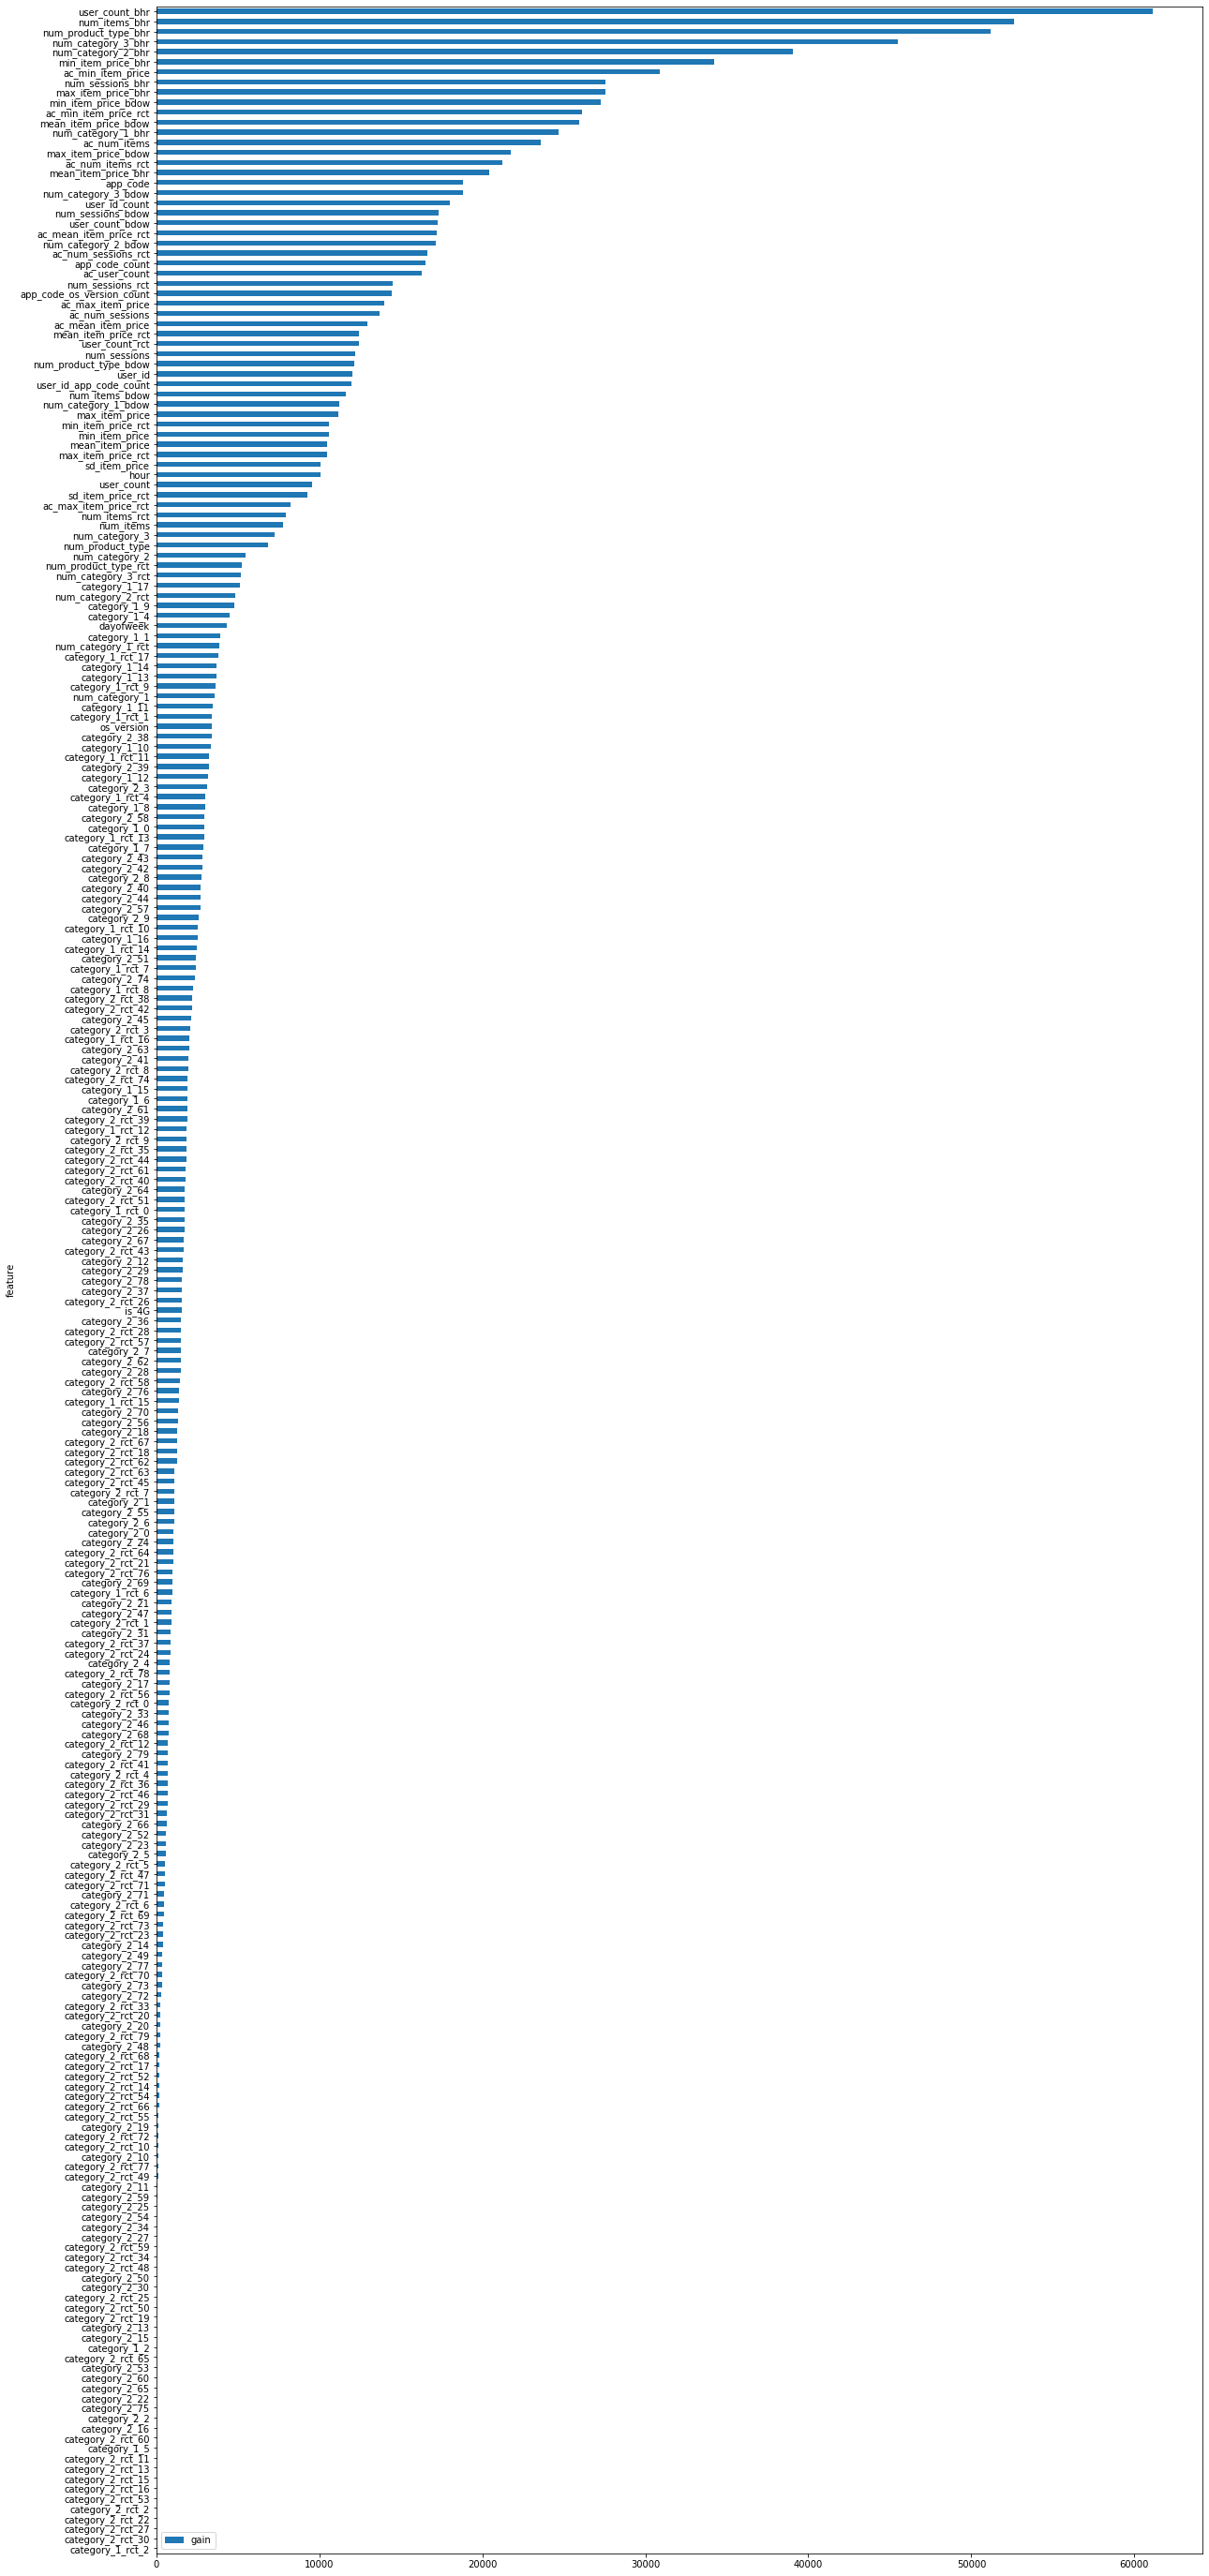

In [38]:
(pd.DataFrame({"feature": model.feature_name(), 
              "gain": model.feature_importance(importance_type="gain")})
     .sort_values("gain", ascending=True).set_index("feature").plot(kind="barh", figsize=(20,50)))